In [7]:
import os
import random
import numpy as np
import torch
from pathlib import Path

# --- ENVIRONMENT SETUP ---
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=1526):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- HYPERPARAMETERS ---
CONFIG = {
    "seed": 1526,
    "img_size": 300,
    "batch_size": 32,
    "num_classes": 7,
    "folds": 5,
    "epochs": 15,
    "lr": 3e-4,
    "device": get_device(),
    # Dynamic worker allocation (safe limit 8)
    "num_workers": min(os.cpu_count(), 8) if os.cpu_count() else 2
}

# --- PATHS (Dynamic) ---
# Detects if running on Kaggle or Local
BASE_DIR = Path("/kaggle/input") if Path("/kaggle/input").exists() else Path("./data")

PATHS = {
    "train_dir": BASE_DIR / "skin-cancer-mnist-ham10000",
    "metadata": BASE_DIR / "skin-cancer-mnist-ham10000/HAM10000_metadata.csv",
    "ext_test": BASE_DIR / "unified-dataset-for-skin-cancer-classification/Unified_dataset/val",
    "weights_dir": Path("./weights") # Where to save models
}

PATHS["weights_dir"].mkdir(exist_ok=True)
set_seed(CONFIG["seed"])

print(f"Environment: {CONFIG['device']} | Workers: {CONFIG['num_workers']}")

Environment: cuda | Workers: 4


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

def plot_training_curves(history, smooth_factor=0.85):
    def smooth(scalars, weight):
        last = scalars[0]
        smoothed = []
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, history['train_loss'], alpha=0.3, label='Train Raw')
    plt.plot(epochs, history['val_loss'], alpha=0.3, label='Val Raw')
    plt.plot(epochs, smooth(history['train_loss'], smooth_factor), label='Train Smooth')
    plt.plot(epochs, smooth(history['val_loss'], smooth_factor), label='Val Smooth')
    plt.title("Loss Curves")
    plt.legend()
    plt.show()

def plot_evaluation_triplet(y_true, y_pred, class_map):
    """
    Plots 3 matrices: 
    1. Counts (Multiclass)
    2. Recall (Multiclass Normalized)
    3. Sensitivity/Specificity (Binary Normalized %)
    """
    class_names = sorted(class_map.keys())
    cm = confusion_matrix(y_true, y_pred)
    
    # Binary Setup
    MALIGNANT = ['mel', 'bcc', 'akiec']
    mal_idxs = [class_map[k] for k in MALIGNANT if k in class_map]
    
    bin_true = [1 if x in mal_idxs else 0 for x in y_true]
    bin_pred = [1 if x in mal_idxs else 0 for x in y_pred]
    
    cm_bin = confusion_matrix(bin_true, bin_pred)
    # Normalize Binary Matrix for Percentages (Sensitivity/Specificity)
    cm_bin_norm = cm_bin.astype('float') / (cm_bin.sum(axis=1)[:, np.newaxis] + 1e-9)

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # 1. Counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
                xticklabels=class_names, yticklabels=class_names)
    axes[0].set_title("Confusion Matrix (Counts)")
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # 2. Recall (Normalized)
    cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds', ax=axes[1],
                xticklabels=class_names, yticklabels=class_names)
    axes[1].set_title("Normalized Matrix (Recall)")
    axes[1].set_xlabel('Predicted Label')

    # 3. Binary (Percentuale)
    sns.heatmap(cm_bin_norm, annot=True, fmt='.1%', cmap='Greens', ax=axes[2],
                xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    axes[2].set_title("Binary Evaluation (Sensitivity & Specificity)")
    axes[2].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

def visualize_tsne(embeddings, labels, class_map, limit=1500):
    if len(embeddings) > limit:
        idx = np.random.choice(len(embeddings), limit, replace=False)
        embeddings = embeddings[idx]
        labels = labels[idx]

    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
    x_embedded = tsne.fit_transform(embeddings)
    
    inv_map = {v: k for k, v in class_map.items()}
    lbl_names = [inv_map[i] for i in labels]

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=x_embedded[:,0], y=x_embedded[:,1], hue=lbl_names, palette='tab10', alpha=0.8)
    plt.title("t-SNE Projection")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

In [9]:
import glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms, models
import torch.nn as nn

# --- DATASET ---
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, row['label_idx']

# --- TRANSFORMS ---
WEIGHTS = models.EfficientNet_B3_Weights.DEFAULT

def get_transforms(img_size):
    # 1. Otteniamo l'oggetto trasformazione predefinito dai pesi
    auto_transform = WEIGHTS.transforms()
    
    # 2. Leggiamo le statistiche direttamente dall'oggetto (sicuro e version-agnostic)
    # Nota: auto_transform è un'istanza di ImageClassification che ha attributi .mean e .std
    mean = auto_transform.mean
    std = auto_transform.std
    
    # 3. Creiamo la normalizzazione esplicita
    norm_layer = transforms.Normalize(mean=mean, std=std)
    
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        norm_layer, # Usiamo il layer creato con i dati estratti
        transforms.RandomErasing(p=0.2)
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        norm_layer
    ])
    
    return train_transform, val_transform

# --- MODEL ---
def build_model(num_classes, device):
    model = models.efficientnet_b3(weights=WEIGHTS)
    
    # Replace Head
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features, num_classes)
    )
    return model.to(device)

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF

# --- LOSS ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        f_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean': return torch.mean(f_loss)
        elif self.reduction == 'sum': return torch.sum(f_loss)
        return f_loss

# --- MIXUP ---
def mixup_data(x, y, alpha=0.4, device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    index = torch.randperm(x.size(0)).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- TRAINER ---
class Trainer:
    def __init__(self, model, optimizer, scheduler, criterion, device):
        self.model = model
        self.opt = optimizer
        self.sched = scheduler
        self.crit = criterion
        self.device = device
        self.scaler = torch.amp.GradScaler('cuda')

    def train_epoch(self, loader):
        self.model.train()
        avg_loss = 0
        
        for x, y in tqdm(loader, desc="Train", leave=False):
            x, y = x.to(self.device), y.to(self.device)
            
            x, y_a, y_b, lam = mixup_data(x, y, alpha=0.4, device=self.device)
            
            self.opt.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda'):
                out = self.model(x)
                loss = mixup_criterion(self.crit, out, y_a, y_b, lam)
            
            self.scaler.scale(loss).backward()
            self.scaler.step(self.opt)
            self.scaler.update()
            avg_loss += loss.item()
            
        return avg_loss / len(loader)

    @torch.no_grad()
    def validate(self, loader):
        self.model.eval()
        avg_loss = 0
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            out = self.model(x)
            loss = self.crit(out, y)
            avg_loss += loss.item()
        return avg_loss / len(loader)

# --- TTA HELPERS ---
@torch.no_grad()
def run_tta(model, loader, device):
    model.eval()
    all_preds = []
    for images, _ in tqdm(loader, desc="TTA Inference", leave=False):
        images = images.to(device)
        p1 = model(images).softmax(1)
        p2 = model(TF.hflip(images)).softmax(1)
        p3 = model(TF.vflip(images)).softmax(1)
        p_avg = (p1 + p2 + p3) / 3.0
        all_preds.append(p_avg.cpu().numpy())
    return np.vstack(all_preds)

Dataset Size: 7470


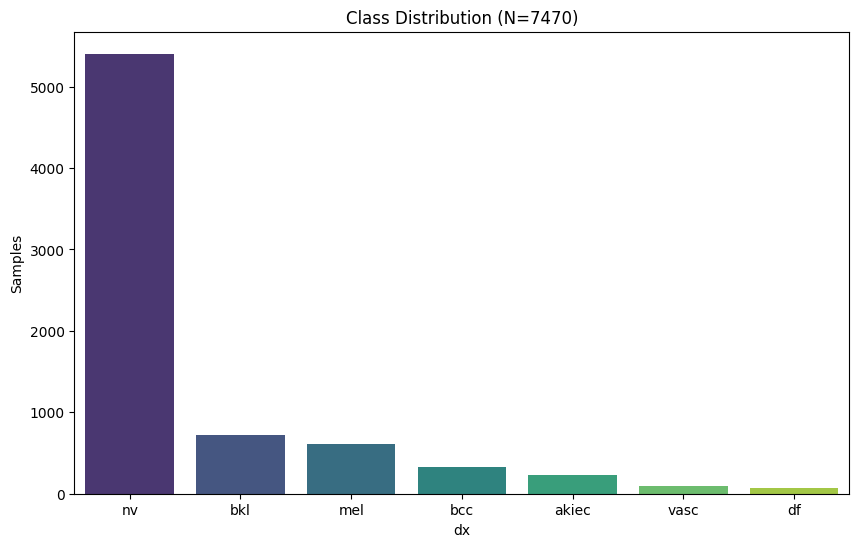

In [11]:
# 1. Image Discovery
img_pattern = str(PATHS["train_dir"] / "**" / "*.jpg")
image_map = {Path(x).stem: x for x in glob.glob(img_pattern, recursive=True)}

# 2. DataFrame Construction
df = pd.read_csv(PATHS["metadata"])
df['path'] = df['image_id'].map(image_map)

# 3. Deduplication (Per user request: drop duplicates on lesion_id)
df_unique = df.drop_duplicates(subset=['lesion_id'], keep='first').reset_index(drop=True)

# 4. Target Encoding
CLASSES_MAP = {label: idx for idx, label in enumerate(sorted(df_unique['dx'].unique()))}
df_unique['label_idx'] = df_unique['dx'].map(CLASSES_MAP)

print(f"Dataset Size: {len(df_unique)}")
plot_class_distribution(df_unique)


>>> FOLD 1/5


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 1 | T: 0.7480 | V: 0.3302


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.5733 | V: 0.2864


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.5094 | V: 0.2423


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4760 | V: 0.2597


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4145 | V: 0.2191


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.3800 | V: 0.2297


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.4107 | V: 0.1987


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.3788 | V: 0.1953


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3837 | V: 0.1926


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.4113 | V: 0.2191


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3923 | V: 0.1854


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3609 | V: 0.1815


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3292 | V: 0.1793


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3813 | V: 0.1927


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3415 | V: 0.1717


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


>>> FOLD 2/5


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 1 | T: 0.7650 | V: 0.3041


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.5363 | V: 0.2624


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.5088 | V: 0.2291


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4612 | V: 0.2265


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4626 | V: 0.2583


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.4361 | V: 0.2491


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.4316 | V: 0.2070


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.4008 | V: 0.2090


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3782 | V: 0.2357


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.3907 | V: 0.1848


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3469 | V: 0.2158


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3501 | V: 0.2066


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3405 | V: 0.1947


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3676 | V: 0.1828


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3404 | V: 0.1765


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


>>> FOLD 3/5


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 1 | T: 0.7513 | V: 0.4160


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.5556 | V: 0.3239


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.4953 | V: 0.2810


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4631 | V: 0.2698


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4737 | V: 0.2537


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.4140 | V: 0.2482


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.4119 | V: 0.2505


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.3806 | V: 0.2300


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3391 | V: 0.2468


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.3741 | V: 0.2187


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3768 | V: 0.2380


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3782 | V: 0.2185


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3561 | V: 0.2215


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3396 | V: 0.2101


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3603 | V: 0.2169


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


>>> FOLD 4/5


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 1 | T: 0.7103 | V: 0.3037


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.5454 | V: 0.3050


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.4715 | V: 0.2755


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4319 | V: 0.2057


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4544 | V: 0.2350


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.3997 | V: 0.2705


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.4107 | V: 0.2273


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.3720 | V: 0.2143


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3528 | V: 0.2127


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.3704 | V: 0.1930


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3688 | V: 0.1936


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3510 | V: 0.1974


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3553 | V: 0.1934


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3236 | V: 0.1927


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3600 | V: 0.1921


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


>>> FOLD 5/5


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 1 | T: 0.7440 | V: 0.2875


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.5636 | V: 0.2745


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.5133 | V: 0.2340


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4549 | V: 0.2537


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4649 | V: 0.2594


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.4035 | V: 0.1992


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.3981 | V: 0.1805


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.3860 | V: 0.1867


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3778 | V: 0.1975


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.3626 | V: 0.2030


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3733 | V: 0.2157


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3223 | V: 0.1922


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3642 | V: 0.1811


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3575 | V: 0.1838


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3570 | V: 0.2043


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


Training Complete.


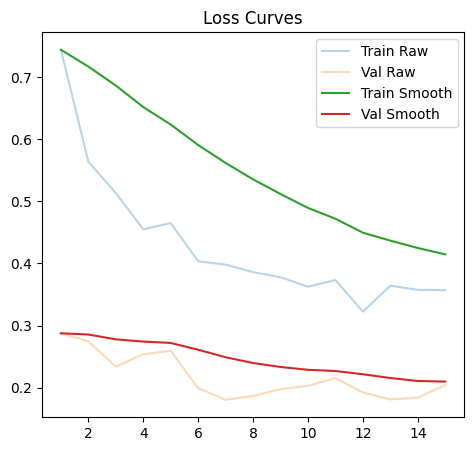

In [12]:
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset

train_tf, val_tf = get_transforms(CONFIG["img_size"])
targets = df_unique['label_idx'].values

# Storage for Analysis
oof_preds = np.zeros((len(df_unique), CONFIG["num_classes"]))
oof_targets = np.zeros(len(df_unique))
feature_storage = [] # For t-SNE later
history_log = {'train_loss': [], 'val_loss': []}

skf = StratifiedKFold(n_splits=CONFIG["folds"], shuffle=True, random_state=CONFIG["seed"])

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n>>> FOLD {fold+1}/{CONFIG['folds']}")
    
    # 1. Data Loading
    train_sub = Subset(SkinDataset(df_unique, train_tf), train_idx)
    val_sub = Subset(SkinDataset(df_unique, val_tf), val_idx)
    
    # Weighted Sampler for Imbalance
    y_train = targets[train_idx]
    class_weights = 1. / np.bincount(y_train)
    sample_weights = [class_weights[t] for t in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    train_loader = DataLoader(
        train_sub, batch_size=CONFIG["batch_size"], sampler=sampler, 
        num_workers=CONFIG["num_workers"], pin_memory=True
    )
    val_loader = DataLoader(
        val_sub, batch_size=CONFIG["batch_size"], shuffle=False, 
        num_workers=CONFIG["num_workers"], pin_memory=True
    )
    
    # 2. Setup
    model = build_model(CONFIG["num_classes"], CONFIG["device"])
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG["epochs"])
    criterion = FocalLoss(gamma=2.0)
    
    trainer = Trainer(model, optimizer, scheduler, criterion, CONFIG["device"])
    
    # 3. Loop
    best_loss = float('inf')
    fold_train_hist, fold_val_hist = [], []
    
    for epoch in range(CONFIG["epochs"]):
        t_loss = trainer.train_epoch(train_loader)
        v_loss = trainer.validate(val_loader)
        scheduler.step()
        
        fold_train_hist.append(t_loss)
        fold_val_hist.append(v_loss)
        
        if v_loss < best_loss:
            best_loss = v_loss
            save_path = PATHS["weights_dir"] / f"effnetb3_fold{fold}.pth"
            torch.save(model.state_dict(), save_path)
            
        print(f"Ep {epoch+1} | T: {t_loss:.4f} | V: {v_loss:.4f}")

    # 4. OOF Inference (Best Model)
    model.load_state_dict(torch.load(save_path))
    oof_preds[val_idx] = run_tta(model, val_loader, CONFIG["device"])
    oof_targets[val_idx] = targets[val_idx]
    
    # Log Last fold history for plotting
    history_log['train_loss'] = fold_train_hist
    history_log['val_loss'] = fold_val_hist

    # Extract embeddings for t-SNE (Sample from Validation)
    model.classifier = nn.Identity()
    with torch.no_grad():
        for i, (imgs, lbls) in enumerate(val_loader):
            if i > 5: break # Limit size
            emb = model(imgs.to(CONFIG["device"])).cpu().numpy()
            feature_storage.append((emb, lbls.numpy()))

print("\nTraining Complete.")
plot_training_curves(history_log)

>>> OOF EVALUATION

=== CLASSIFICATION REPORT (OOF) ===
              precision    recall  f1-score   support

       akiec       0.69      0.62      0.65       228
         bcc       0.76      0.86      0.81       327
         bkl       0.77      0.76      0.76       727
          df       0.81      0.60      0.69        73
         mel       0.51      0.69      0.59       614
          nv       0.96      0.92      0.94      5403
        vasc       0.84      0.90      0.87        98

    accuracy                           0.87      7470
   macro avg       0.76      0.76      0.76      7470
weighted avg       0.88      0.87      0.88      7470



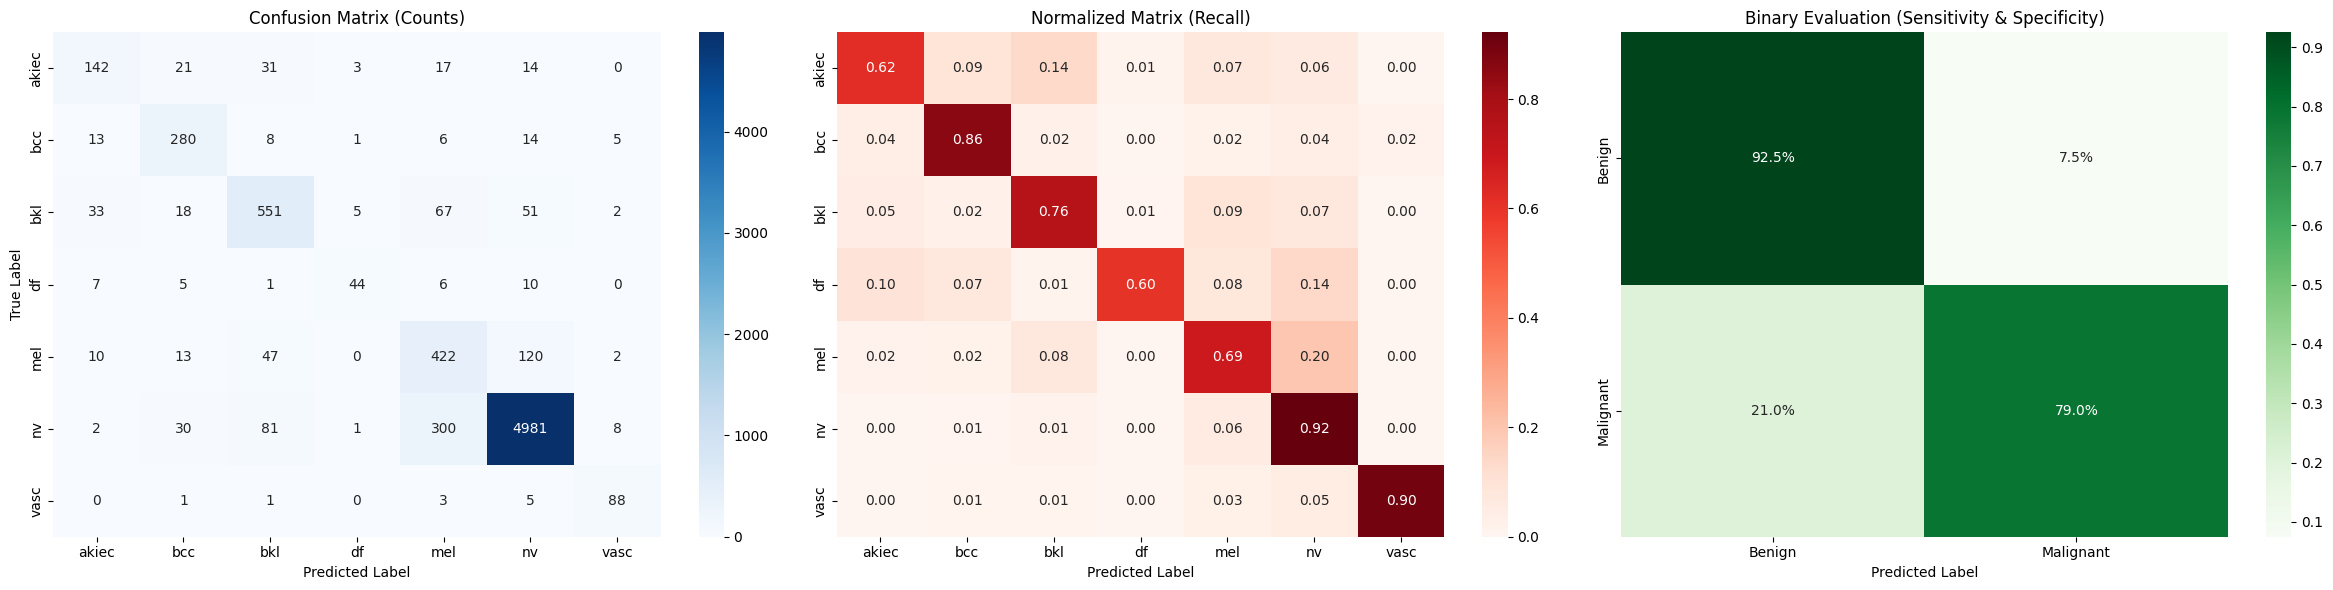

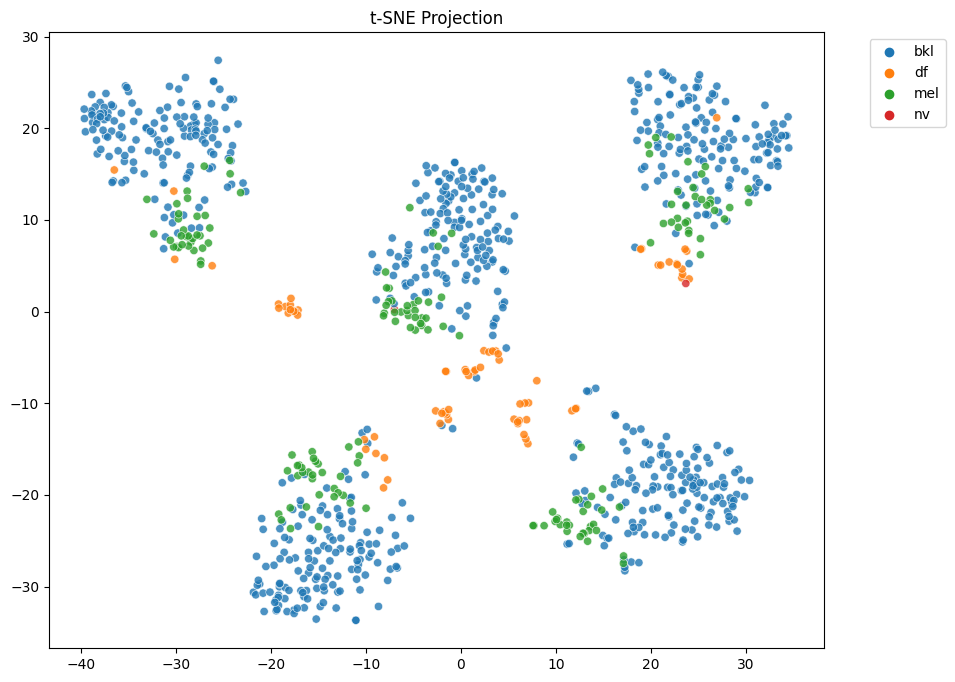

In [39]:
from sklearn.metrics import classification_report

print(">>> OOF EVALUATION")
y_pred_cls = np.argmax(oof_preds, axis=1)
y_true = oof_targets.astype(int)

# 1. Classification Report
print("\n=== CLASSIFICATION REPORT (OOF) ===")
print(classification_report(y_true, y_pred_cls, target_names=sorted(CLASSES_MAP.keys())))

# 2. Plot Triplet (Counts, Recall, Binary)
plot_evaluation_triplet(y_true, y_pred_cls, CLASSES_MAP)

# 3. t-SNE
if feature_storage:
    all_embs = np.concatenate([x[0] for x in feature_storage])
    all_lbls = np.concatenate([x[1] for x in feature_storage])
    visualize_tsne(all_embs, all_lbls, CLASSES_MAP)


>>> EXTERNAL TEST EVALUATION
Subsampling External Test from 8283 to 2000 images...
Running Ensemble Inference...


TTA Inference:   0%|          | 0/63 [00:00<?, ?it/s]

TTA Inference:   0%|          | 0/63 [00:00<?, ?it/s]

TTA Inference:   0%|          | 0/63 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0ce197c2c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0ce197c2c0>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    
self._shutdown_workers() 
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():
   ^^ ^ ^^ ^  ^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^^ 
    File "/usr/lib/

TTA Inference:   0%|          | 0/63 [00:00<?, ?it/s]

TTA Inference:   0%|          | 0/63 [00:00<?, ?it/s]


=== CLASSIFICATION REPORT (EXTERNAL) ===
              precision    recall  f1-score   support

       akiec       0.36      0.28      0.31       140
         bcc       0.77      0.54      0.63       417
         bkl       0.29      0.54      0.38       123
          df       0.44      0.38      0.41        21
         mel       0.79      0.35      0.49       497
          nv       0.65      0.92      0.76       773
        vasc       0.44      0.52      0.48        29

    accuracy                           0.62      2000
   macro avg       0.53      0.50      0.49      2000
weighted avg       0.66      0.62      0.60      2000



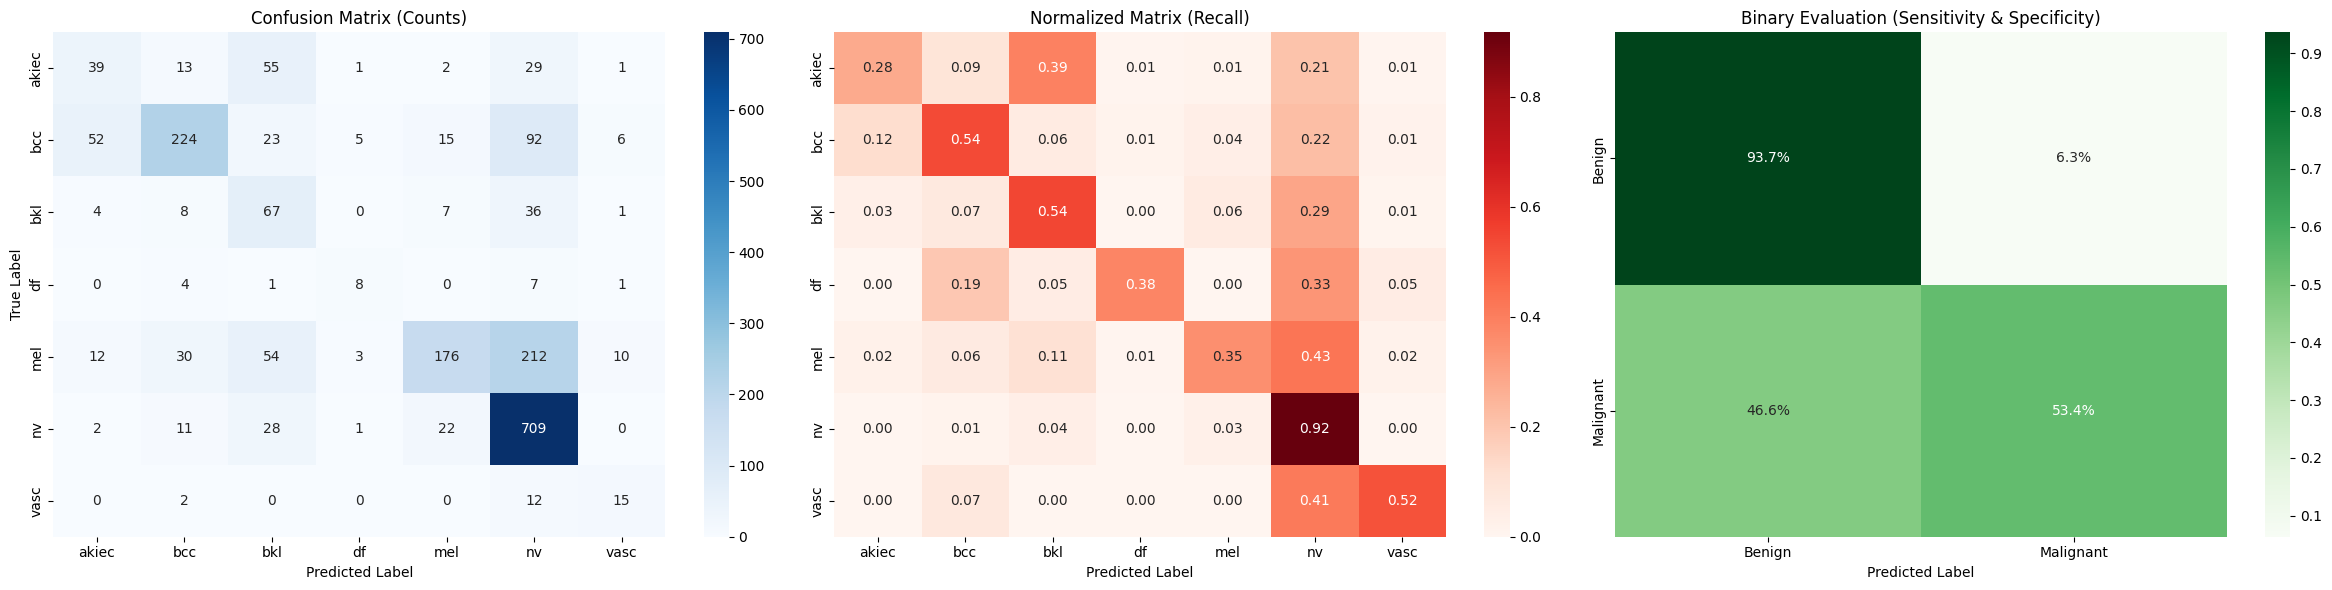

In [40]:
class ExternalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = glob.glob(str(root_dir / "**" / "*.jpg"), recursive=True)
        self.transform = transform
        
    def __len__(self): 
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        label_str = Path(path).parent.name
        img = self.transform(Image.open(path).convert("RGB"))
        return img, CLASSES_MAP.get(label_str, -1) 

if PATHS["ext_test"].exists():
    print("\n>>> EXTERNAL TEST EVALUATION")
    ext_ds = ExternalDataset(PATHS["ext_test"], transform=val_tf)
    
    # Subsampling logic
    if len(ext_ds) > 2000:
        print(f"Subsampling External Test from {len(ext_ds)} to 2000 images...")
        indices = np.random.choice(len(ext_ds), 2000, replace=False)
        ext_ds = Subset(ext_ds, indices)
    
    ext_loader = DataLoader(ext_ds, batch_size=CONFIG["batch_size"], num_workers=CONFIG["num_workers"])
    
    # Ensemble Prediction
    model = build_model(CONFIG["num_classes"], CONFIG["device"])
    ens_preds = []
    
    print("Running Ensemble Inference...")
    for fold in range(CONFIG["folds"]):
        w_path = PATHS["weights_dir"] / f"effnetb3_fold{fold}.pth"
        if w_path.exists():
            model.load_state_dict(torch.load(w_path, map_location=CONFIG["device"]))
            ens_preds.append(run_tta(model, ext_loader, CONFIG["device"]))
        
    avg_preds = np.mean(ens_preds, axis=0)
    final_preds = np.argmax(avg_preds, axis=1)
    
    # Retrieve Labels
    y_true_ext = []
    # Loop needed because Subset wrapper hides direct access
    for i in range(len(ext_ds)):
        _, lbl = ext_ds[i]
        y_true_ext.append(lbl)
    
    y_true_ext = np.array(y_true_ext)
    
    # Filter invalid labels
    valid_mask = y_true_ext != -1
    y_true_clean = y_true_ext[valid_mask]
    y_pred_clean = final_preds[valid_mask]

    # Reports
    print("\n=== CLASSIFICATION REPORT (EXTERNAL) ===")
    print(classification_report(y_true_clean, y_pred_clean, target_names=sorted(CLASSES_MAP.keys())))
    
    plot_evaluation_triplet(y_true_clean, y_pred_clean, CLASSES_MAP)
else:
    print("External dataset path not found.")

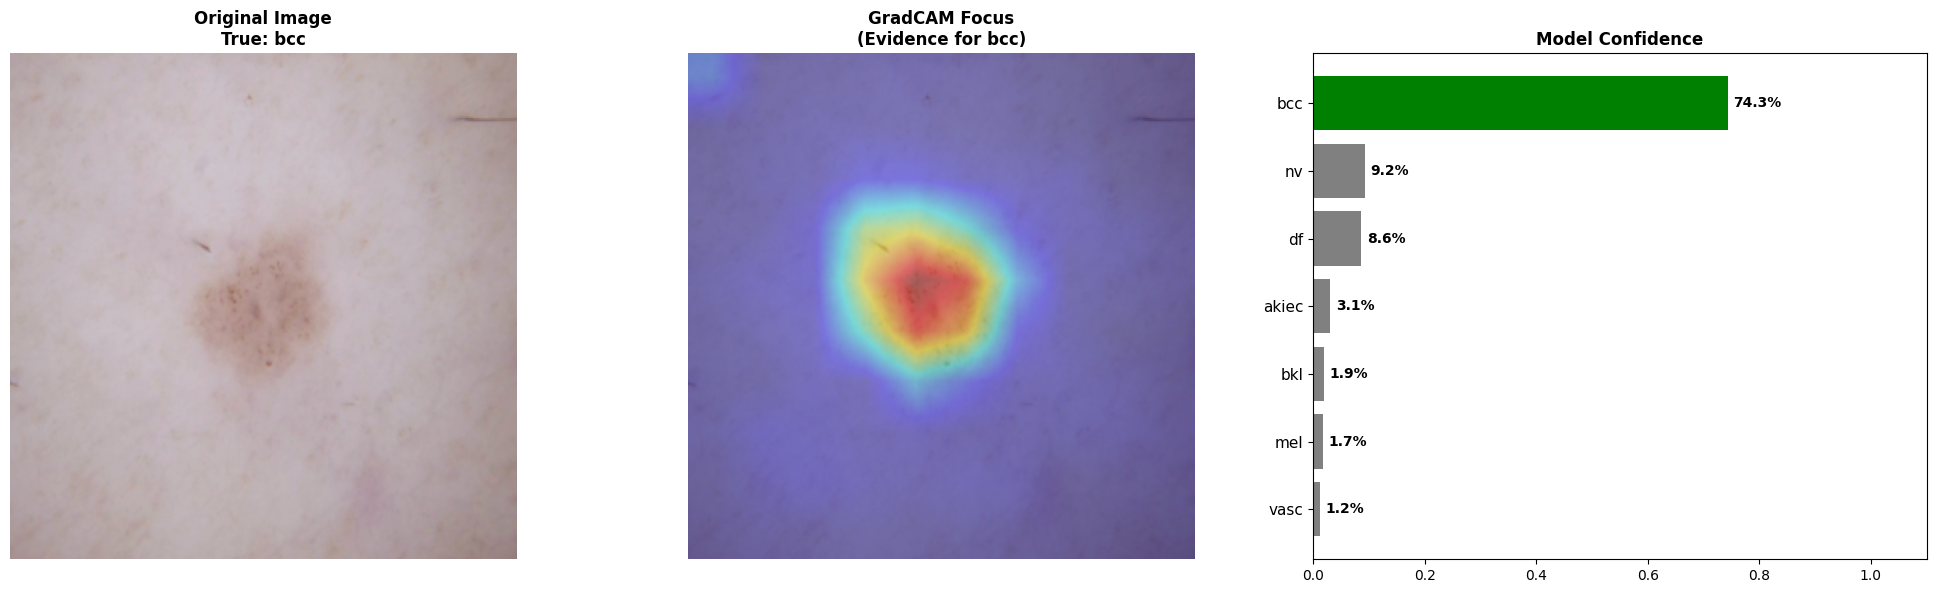

In [37]:
import cv2

# --- GRADCAM CORE ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        # Hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx):
        output = self.model(x)
        self.model.zero_grad()
        output[0, class_idx].backward()
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activation = self.activations[0]
        
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=0).cpu().detach().numpy()
        return np.maximum(heatmap, 0)

# --- VISUALIZATION LOGIC ---
def visualize_sample_with_confidence(model, dataset, device, classes_map):
    # 1. Pick Random Sample
    idx = random.randint(0, len(dataset)-1)
    img_tensor, label_idx = dataset[idx]
    
    class_names = sorted(classes_map.keys())
    true_label_name = class_names[label_idx]
    
    # 2. Inference (Get Probabilities)
    model.eval()
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Re-init GradCAM specifically for this instance to attach hooks correctly
    target_layer = model.features[-1]
    cam = GradCAM(model, target_layer)
    
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    
    # 3. Generate Heatmap (Focus on Predicted Class or True Class? Let's focus on True Class)
    # Enable grad for CAM calculation
    with torch.enable_grad():
        heatmap = cam(input_tensor, label_idx)

    # 4. Create Overlay (OpenCV Style)
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    rgb_img = inv_normalize(img_tensor).permute(1, 2, 0).cpu().numpy()
    rgb_img = np.clip(rgb_img, 0, 1)

    heatmap_resized = cv2.resize(heatmap, (rgb_img.shape[1], rgb_img.shape[0]))
    if np.max(heatmap_resized) != 0: 
        heatmap_resized /= np.max(heatmap_resized)
    
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255
    
    overlay = heatmap_colored * 0.4 + rgb_img * 0.6
    overlay = np.clip(overlay, 0, 1)

    # 5. Plotting (3 Columns: Original | Overlay | Confidence)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # A. Original
    axes[0].imshow(rgb_img)
    axes[0].set_title(f"Original Image\nTrue: {true_label_name}", fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # B. GradCAM
    axes[1].imshow(overlay)
    axes[1].set_title(f"GradCAM Focus\n(Evidence for {true_label_name})", fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # C. Confidence Bar Chart
    sorted_idxs = np.argsort(probs)
    sorted_probs = probs[sorted_idxs]
    sorted_names = [class_names[i] for i in sorted_idxs]
    
    colors = ['gray'] * len(sorted_names)
    # Highlight True Label in Green
    if true_label_name in sorted_names:
        colors[sorted_names.index(true_label_name)] = 'green'
        
    y_pos = np.arange(len(sorted_names))
    axes[2].barh(y_pos, sorted_probs, color=colors)
    axes[2].set_yticks(y_pos)
    axes[2].set_yticklabels(sorted_names, fontsize=11)
    axes[2].set_title("Model Confidence", fontsize=12, fontweight='bold')
    axes[2].set_xlim(0, 1.1)
    
    # Add text labels
    for i, v in enumerate(sorted_probs):
        axes[2].text(v + 0.01, i, f"{v:.1%}", va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
# Load Model (Ensure weights exist)
model_xai = build_model(CONFIG["num_classes"], CONFIG["device"])
weights_path = PATHS["weights_dir"] / "effnetb3_fold0.pth"

if weights_path.exists():
    model_xai.load_state_dict(torch.load(weights_path, map_location=CONFIG["device"]))
    # Run Visualization
    ds = SkinDataset(df_unique, transform=val_tf)
    visualize_sample_with_confidence(model_xai, ds, CONFIG["device"], CLASSES_MAP)
else:
    print("No weights found. Run training first.")

In [16]:
import gradio as gr

def inference_pipeline(image):
    if image is None: return None
    # Preprocess
    img_t = val_tf(image.convert("RGB")).unsqueeze(0).to(CONFIG["device"])
    
    # Predict
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(img_t), dim=1).cpu().numpy()[0]
        
    return {class_names[i]: float(probs[i]) for i in range(len(class_names))}

demo = gr.Interface(
    fn=inference_pipeline,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=3),
    title="Skin Lesion Classifier (B3)"
)

if __name__ == "__main__":
    demo.launch(share=True, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://96e6aacbc09c7c0f19.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://96e6aacbc09c7c0f19.gradio.live
